In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from loguru import logger
import warnings
import re
import emoji

warnings.filterwarnings("ignore", category=FutureWarning)

In [15]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.columns
# df.info()

Index(['timestamp', 'message', 'author', 'has_emoji', 'is_topk',
       'message_length', 'has_link', 'timestamp_category', 'hour',
       'day_of_week', 'msg_length'],
      dtype='object')

In [16]:
# Count the amount of messages for top 15 authors.
p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]

In [17]:
topk_authors = list(topk.index)
# topk_authors

In [18]:
# Define the authors to select
selected_authors = ["intense-toad", "vivid-rhinoceros", "zany-trout"]

# Define the rename map
rename_map = {
    "intense-toad": "Voorzitter",
    "vivid-rhinoceros": "Attent bewoner",
    "zany-trout": "Klusjesman bewoner"
}

# Filter the original df for selected authors
df_selected = df[df['author'].isin(selected_authors)].copy()

# Apply the rename mapping
df_selected['author'] = df_selected['author'].map(rename_map)

# Verify
# df_selected.head()



In [19]:
# Extract year
df_selected['year'] = df_selected['timestamp'].dt.year

# Count messages per author per year
df_counts = (
    df_selected.groupby(['author', 'year'])
    .size()
    .reset_index(name='message_count')
)

# Get min and max year in the data
min_year, max_year = df_counts['year'].min(), df_counts['year'].max()

def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

df_selected['emoji_count'] = df_selected['message'].apply(count_emojis)


# Create a 'year_month' column
df_selected['year_month'] = df_selected['timestamp'].dt.to_period('M').dt.to_timestamp()

# Aggregate counts per author per month
monthly_counts = df_selected.groupby(['year_month', 'author']).size().reset_index(name='message_count')

# Create a 'year_quarter' column
df_selected['year_quarter'] = df_selected['timestamp'].dt.to_period('Q').dt.start_time

# Aggregate counts per author per quarter
quarterly_counts = df_selected.groupby(['year_quarter', 'author']).size().reset_index(name='message_count')


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_52232/1253462598.py:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_selected['year_month'] = df_selected['timestamp'].dt.to_period('M').dt.to_timestamp()
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_52232/1253462598.py:27: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_selected['year_quarter'] = df_selected['timestamp'].dt.to_period('Q').dt.start_time


In [20]:
# Ensure emoji_count exists
if 'emoji_count' not in df_selected.columns:
    import emoji
    def count_emojis(text):
        return len([c for c in text if c in emoji.EMOJI_DATA])
    df_selected['emoji_count'] = df_selected['message'].apply(count_emojis)

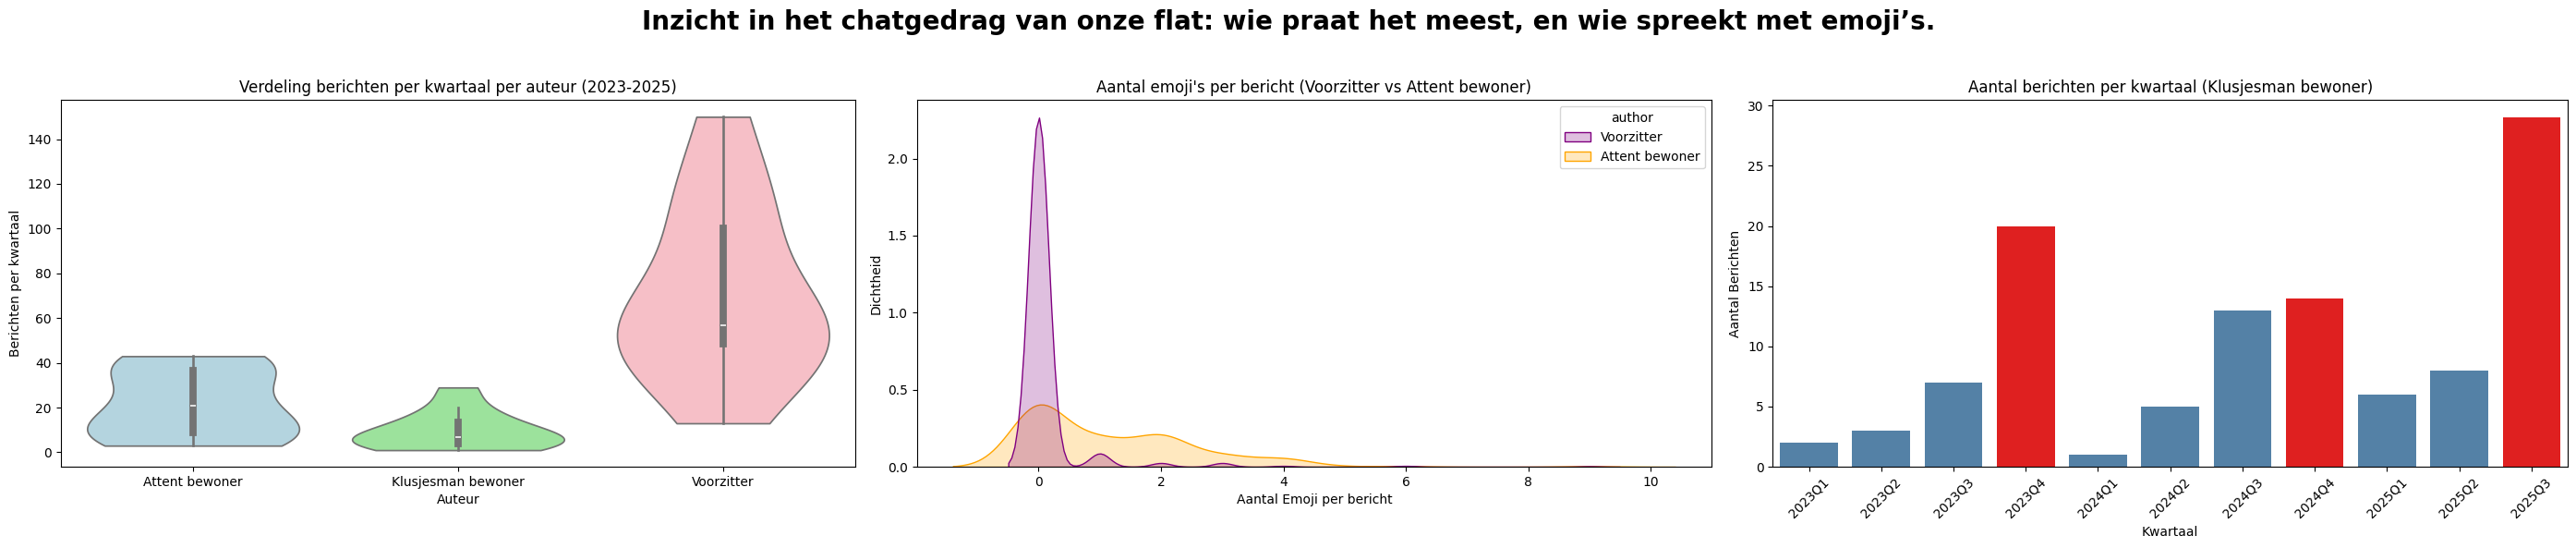

In [21]:
# Create subplots with 3 plots side by side
fig, axes = plt.subplots(1, 3, figsize=(28, 6))

# === 1. Violinplot: quarterly message distribution per author ===
sns.violinplot(
    ax=axes[0],
    data=quarterly_counts,
    x='author',
    y='message_count',
    inner='box',
    cut=0,
    palette=["#ADD8E6", "#90EE90", "#FFB6C1"]
)
axes[0].set_title("Verdeling berichten per kwartaal per auteur (2023-2025)")
axes[0].set_xlabel("Auteur")
axes[0].set_ylabel("Berichten per kwartaal")

# === 2. KDE plot: emoji counts (Voorzitter vs Attent bewoner) ===
sns.kdeplot(
    ax=axes[1],
    data=df_selected[df_selected['author'].isin(["Voorzitter", "Attent bewoner"])],
    x='emoji_count',
    hue='author',
    fill=True,
    common_norm=False,
    palette=["purple", "orange"]
)
axes[1].set_title("Aantal emoji's per bericht (Voorzitter vs Attent bewoner)")
axes[1].set_xlabel("Aantal Emoji per bericht")
axes[1].set_ylabel("Dichtheid")

# === 3. Barplot: quarterly counts for Klusjesman bewoner ===
klusjesman_df = df_selected[df_selected['author'] == "Klusjesman bewoner"].copy()
klusjesman_df['timestamp_naive'] = klusjesman_df['timestamp'].dt.tz_convert(None)
klusjesman_df['year_quarter'] = klusjesman_df['timestamp_naive'].dt.to_period('Q')

quarterly_counts_klusjes = klusjesman_df.groupby('year_quarter').size().reset_index(name='message_count')
quarterly_counts_klusjes['year'] = quarterly_counts_klusjes['year_quarter'].dt.year

idx_max_per_year = quarterly_counts_klusjes.groupby('year')['message_count'].idxmax()
quarterly_counts_klusjes['color'] = 'steelblue'
quarterly_counts_klusjes.loc[idx_max_per_year, 'color'] = 'red'
palette_list = quarterly_counts_klusjes['color'].tolist()

sns.barplot(
    ax=axes[2],
    data=quarterly_counts_klusjes,
    x='year_quarter',
    y='message_count',
    palette=palette_list
)
axes[2].set_title("Aantal berichten per kwartaal (Klusjesman bewoner)")
axes[2].set_xlabel("Kwartaal")
axes[2].set_ylabel("Aantal Berichten")
axes[2].tick_params(axis='x', rotation=45)

# === Add a big centered title ===
fig.suptitle("Inzicht in het chatgedrag van onze flat: wie praat het meest, en wie spreekt met emoji’s.", fontsize=20, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leaves space for suptitle
plt.show()


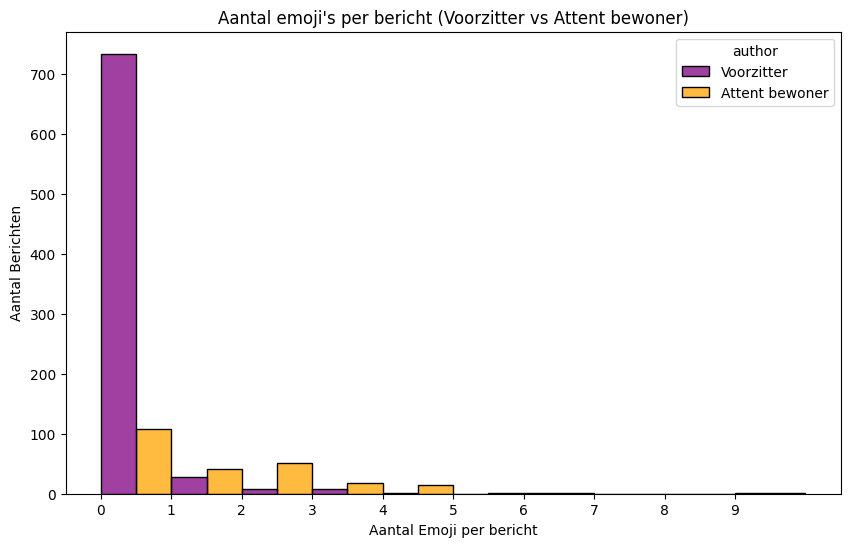

In [23]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
import emoji
import tomllib

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# Load config
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

# Load data
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)

# %%
# Define selected authors and rename map
selected_authors = ["intense-toad", "vivid-rhinoceros", "zany-trout"]
rename_map = {
    "intense-toad": "Voorzitter",
    "vivid-rhinoceros": "Attent bewoner",
    "zany-trout": "Klusjesman bewoner"
}

df_selected = df[df['author'].isin(selected_authors)].copy()
df_selected['author'] = df_selected['author'].map(rename_map)

# %%
# Function to count emojis
def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

df_selected['emoji_count'] = df_selected['message'].apply(count_emojis)

# %%
# Filter for the authors we want to plot
authors_to_plot = ["Voorzitter", "Attent bewoner"]
df_plot = df_selected[df_selected['author'].isin(authors_to_plot)]

# %%
# Plot histogram of emoji counts
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_plot,
    x='emoji_count',
    hue='author',
    multiple='dodge',  # bars side by side
    bins=range(df_plot['emoji_count'].max() + 2),
    palette=["purple", "orange"],
    edgecolor="black"
)

plt.title("Aantal emoji's per bericht (Voorzitter vs Attent bewoner)")
plt.xlabel("Aantal Emoji per bericht")
plt.ylabel("Aantal Berichten")
plt.xticks(range(df_plot['emoji_count'].max() + 1))
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_52232/3108586170.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Auteur", bbox_to_anchor=(1.05, 1), loc='upper left')


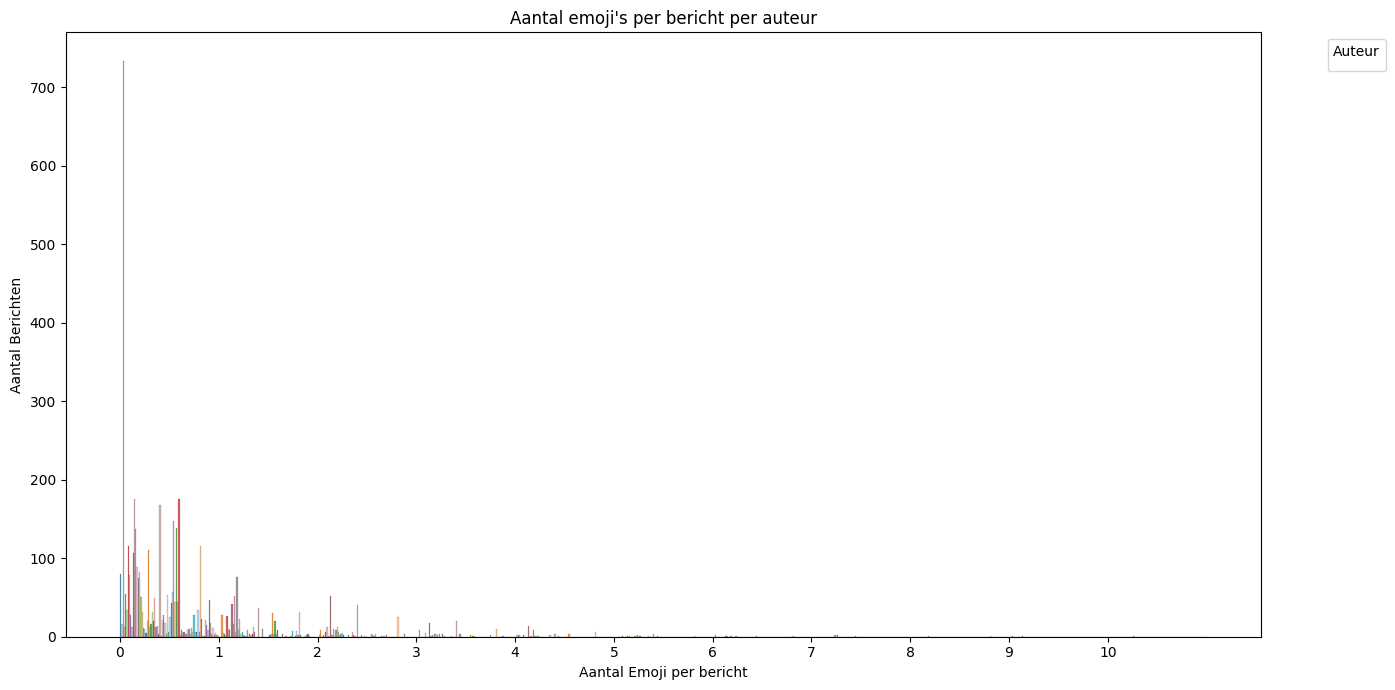

In [24]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
import emoji
import tomllib

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# Load config
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

# Load data
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)

# %%
# Function to count emojis
def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

df['emoji_count'] = df['message'].apply(count_emojis)

# %%
# Plot histogram for all authors
plt.figure(figsize=(14, 7))

# We gebruiken palette automatisch voor alle auteurs
sns.histplot(
    data=df,
    x='emoji_count',
    hue='author',
    multiple='dodge',          # bars naast elkaar
    bins=range(df['emoji_count'].max() + 2),
    palette="tab20",           # automatisch kleurenschema voor meerdere auteurs
    edgecolor="black"
)

plt.title("Aantal emoji's per bericht per auteur")
plt.xlabel("Aantal Emoji per bericht")
plt.ylabel("Aantal Berichten")
plt.xticks(range(df['emoji_count'].max() + 1))
plt.legend(title="Auteur", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_52232/1079839130.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Auteur", bbox_to_anchor=(1.05, 1), loc='upper left')


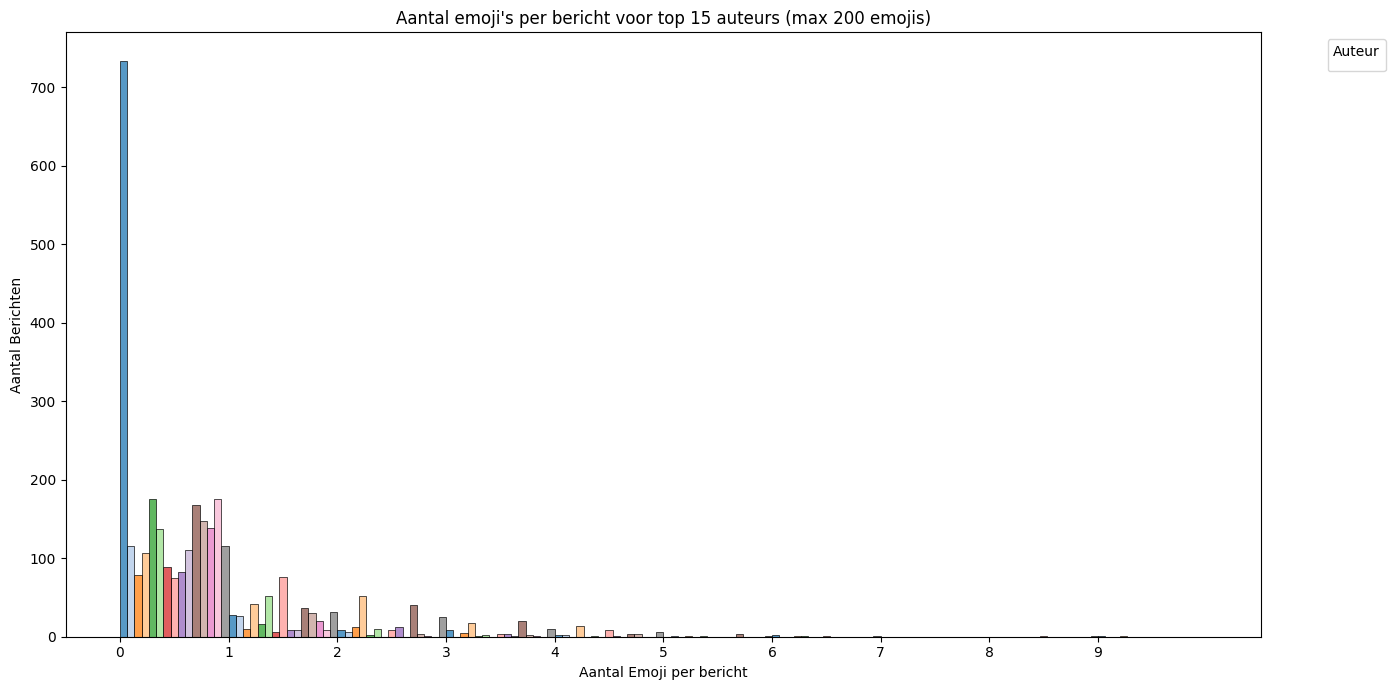

In [26]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
import emoji
import tomllib

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# Load config
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

# Load data
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)

# %%
# Count emojis per message
def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

df['emoji_count'] = df['message'].apply(count_emojis)

# %%
# Select top 15 authors by number of messages
top_authors = df.groupby('author')['message'].count().sort_values(ascending=False).head(15).index
df_top = df[df['author'].isin(top_authors)].copy()

# Filter out messages with more than 200 emojis
df_top = df_top[df_top['emoji_count'] <= 200]

# %%
# Plot histogram of emoji counts for top 15 authors
plt.figure(figsize=(14, 7))

sns.histplot(
    data=df_top,
    x='emoji_count',
    hue='author',
    multiple='dodge',           # bars naast elkaar
    bins=range(df_top['emoji_count'].max() + 2),
    palette="tab20",            # automatisch kleurenschema
    edgecolor="black"
)

plt.title("Aantal emoji's per bericht voor top 15 auteurs (max 200 emojis)")
plt.xlabel("Aantal Emoji per bericht")
plt.ylabel("Aantal Berichten")
plt.xticks(range(df_top['emoji_count'].max() + 1))
plt.legend(title="Auteur", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_52232/162833462.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')


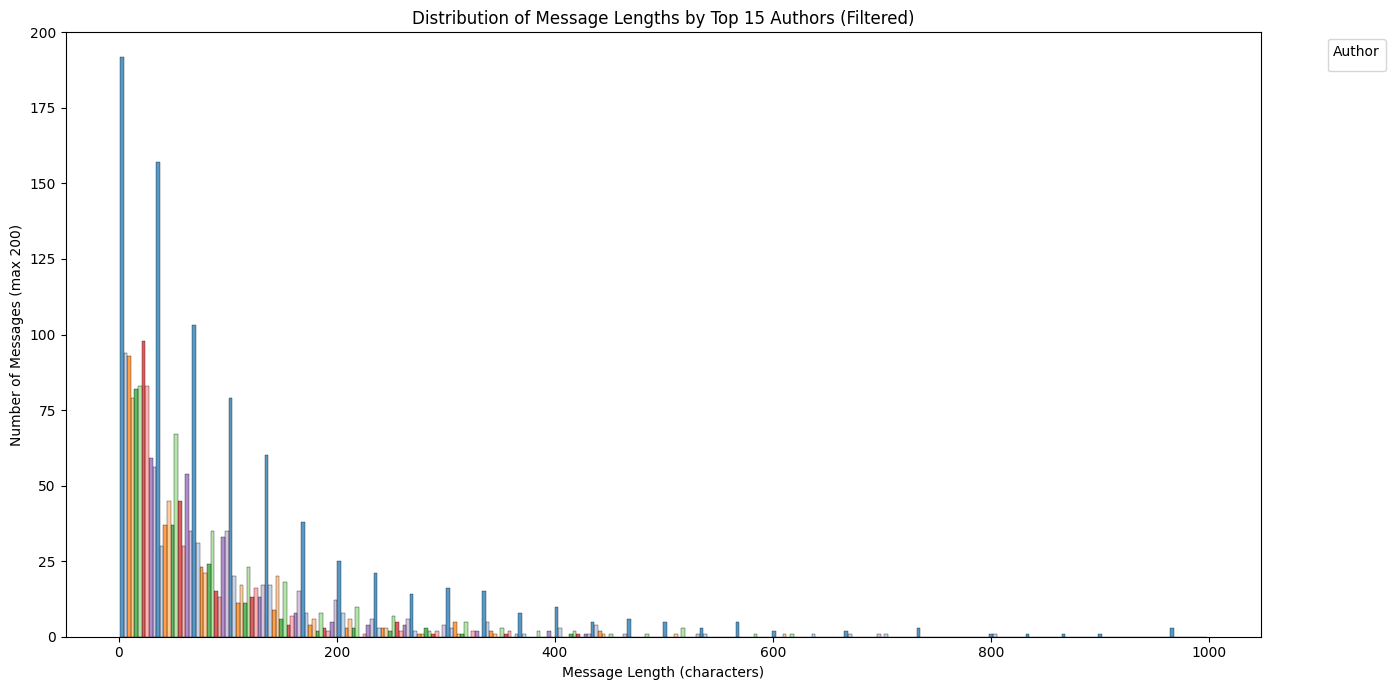

In [29]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
import tomllib

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# Load config and data
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)

# %%
# Select top 15 authors by total number of messages
top_authors = df.groupby('author')['message'].count().sort_values(ascending=False).head(10).index
df_top = df[df['author'].isin(top_authors)].copy()

# Filter message lengths <= 1000
df_top = df_top[df_top['msg_length'] <= 1000]

# %%
# Plot distribution of message lengths per top author
plt.figure(figsize=(14, 7))

ax = sns.histplot(
    data=df_top,
    x='msg_length',
    hue='author',
    multiple='dodge',
    bins=30,
    palette="tab20",
    edgecolor="black"
)

# Limit y-axis to 200
ax.set_ylim(0, 200)

plt.title("Distribution of Message Lengths by Top 15 Authors (Filtered)")
plt.xlabel("Message Length (characters)")
plt.ylabel("Number of Messages (max 200)")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_52232/61627202.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')


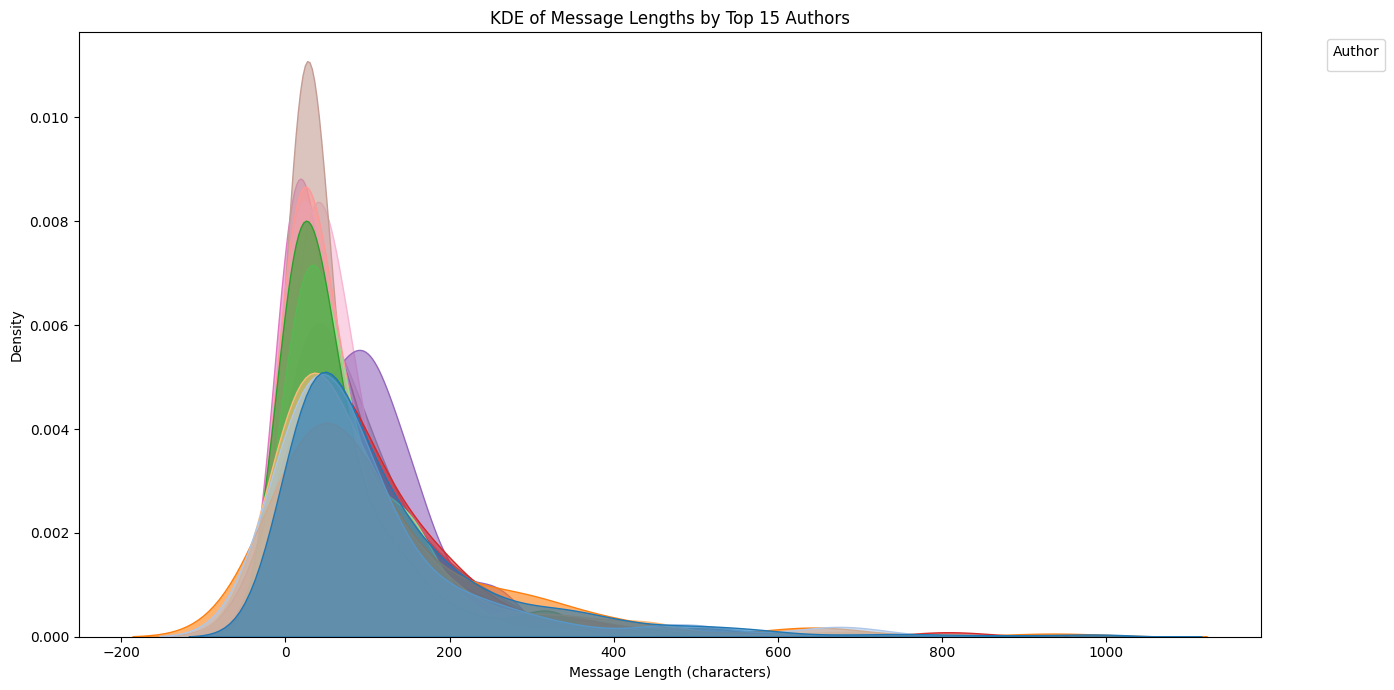

In [31]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
import tomllib

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# Load config and data
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)

# %%
# Select top 15 authors by total number of messages
top_authors = df.groupby('author')['message'].count().sort_values(ascending=False).head(15).index
df_top = df[df['author'].isin(top_authors)].copy()

# Filter out messages longer than 1000 characters (optional for readability)
df_top = df_top[df_top['msg_length'] <= 1000]

# %%
# KDE plot of message lengths per top author
plt.figure(figsize=(14, 7))

sns.kdeplot(
    data=df_top,
    x='msg_length',
    hue='author',
    fill=True,          # fill under the curve
    common_norm=False,  # normalize each author separately
    palette="tab20",
    alpha=0.6
)

plt.title("KDE of Message Lengths by Top 15 Authors")
plt.xlabel("Message Length (characters)")
plt.ylabel("Density")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


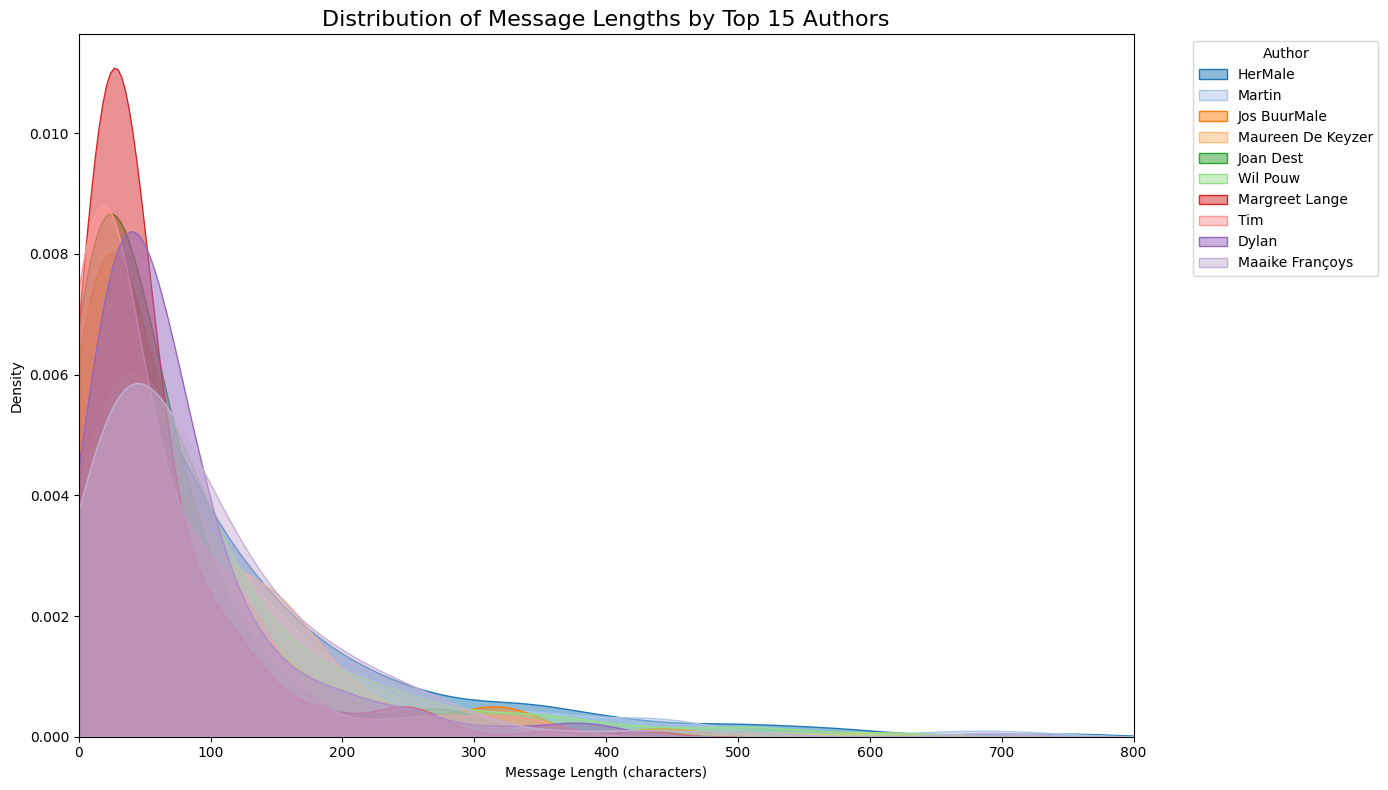

In [38]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import tomllib
import json
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load WhatsApp data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run preprocess first!")
df = pd.read_parquet(datafile)

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
    [['author', 'Name']]  # keep only author id and real name
)

# %%
# --- Compute top 15 authors ---
top_authors = df['author'].value_counts().head(10).index.tolist()

# Filter dataframe for top 15 authors only
df_top = df[df['author'].isin(top_authors)].copy()

# Map author IDs to real names using metadata
author_map = dict(zip(author_info_df['author'], author_info_df['Name']))
df_top['author_name'] = df_top['author'].map(author_map)

# If some authors are missing in metadata, fallback to original ID
df_top['author_name'].fillna(df_top['author'], inplace=True)

# %%
# --- Optional: filter extreme message lengths ---
df_top = df_top[df_top['msg_length'] <= 800]


# --- Plot KDE of message length by author ---
plt.figure(figsize=(14, 8))

# Get unique authors in order
authors = df_top['author_name'].unique()

# Assign a color palette with enough distinct colors
palette = sns.color_palette("tab20", n_colors=len(authors))

# Plot each author's KDE individually
for i, author in enumerate(authors):
    sns.kdeplot(
        data=df_top[df_top['author_name'] == author],
        x='msg_length',
        fill=True,
        common_norm=False,
        alpha=0.5,
        label=author,
        color=palette[i]
    )

plt.title("Distribution of Message Lengths by Top 15 Authors", fontsize=16)
plt.xlabel("Message Length (characters)")
plt.ylabel("Density")

# Legend with author names
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlim(0, 800)
plt.tight_layout()
plt.show()


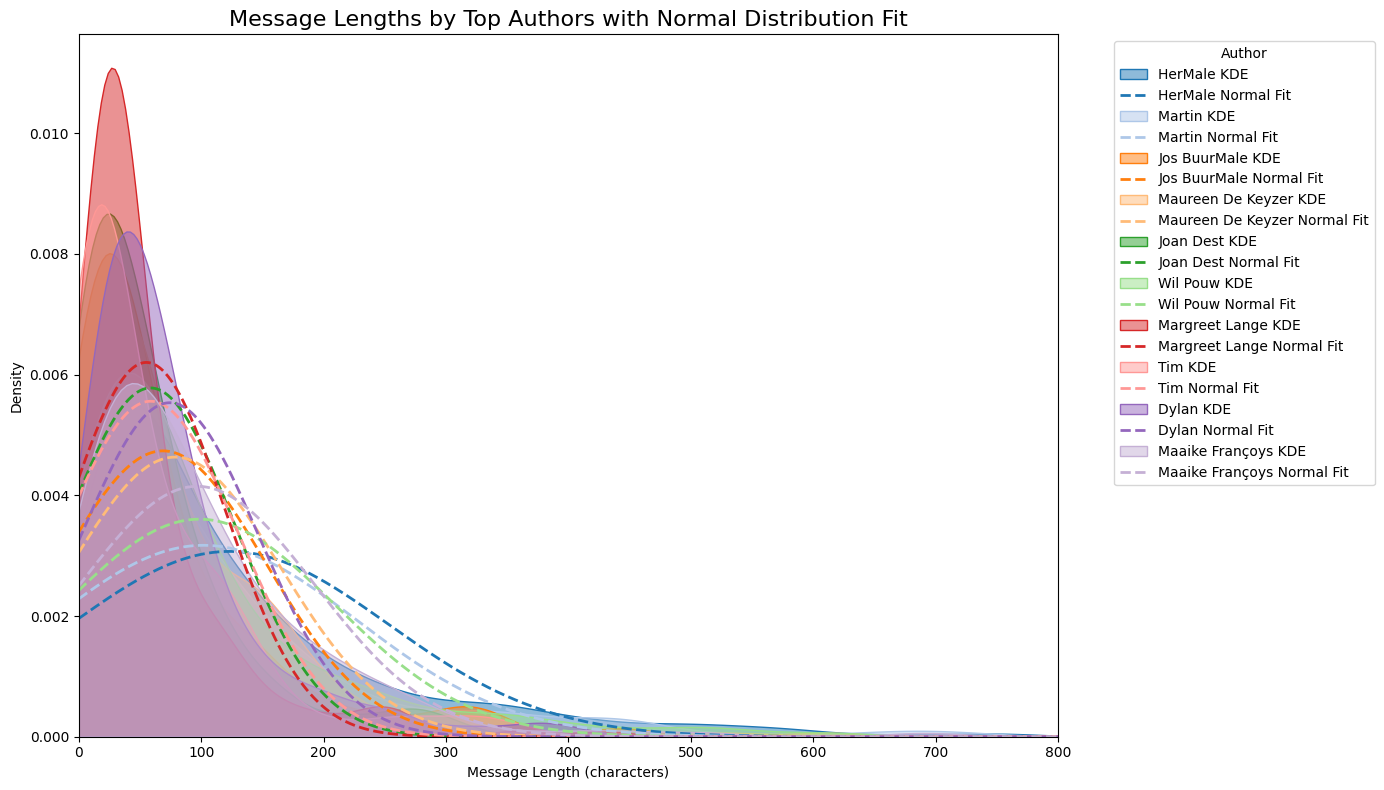

In [39]:
# %%
import numpy as np
from scipy.stats import norm

plt.figure(figsize=(14, 8))

# Get unique authors in order
authors = df_top['author_name'].unique()

# Assign a color palette with enough distinct colors
palette = sns.color_palette("tab20", n_colors=len(authors))

# Plot each author's KDE and normal distribution fit
for i, author in enumerate(authors):
    author_data = df_top[df_top['author_name'] == author]['msg_length']
    
    # KDE
    sns.kdeplot(
        data=author_data,
        fill=True,
        common_norm=False,
        alpha=0.5,
        label=f"{author} KDE",
        color=palette[i]
    )
    
    # Fit normal distribution
    mu, std = norm.fit(author_data)
    x = np.linspace(0, 800, 1000)
    plt.plot(x, norm.pdf(x, mu, std), color=palette[i], linestyle='--', linewidth=2, label=f"{author} Normal Fit")

plt.title("Message Lengths by Top Authors with Normal Distribution Fit", fontsize=16)
plt.xlabel("Message Length (characters)")
plt.ylabel("Density")
plt.xlim(0, 800)
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


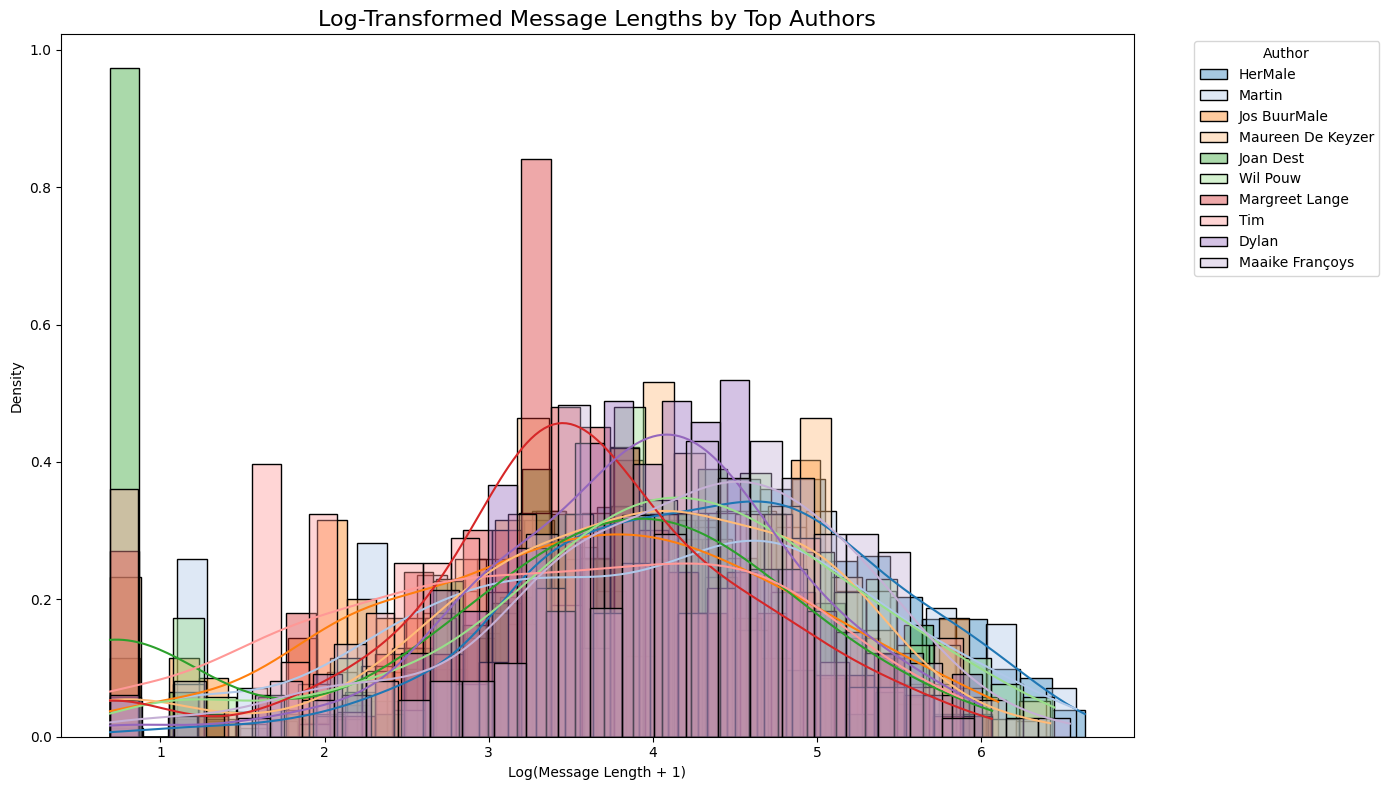

In [40]:
# %%
import numpy as np

# Add log-transformed message length
df_top['log_msg_length'] = df_top['msg_length'].apply(lambda x: np.log(x + 1))  # +1 to avoid log(0)

plt.figure(figsize=(14, 8))

# Plot histogram + KDE for each author
authors = df_top['author_name'].unique()
palette = sns.color_palette("tab20", n_colors=len(authors))

for i, author in enumerate(authors):
    sns.histplot(
        df_top[df_top['author_name'] == author],
        x='log_msg_length',
        kde=True,
        stat="density",
        bins=30,
        alpha=0.4,
        color=palette[i],
        label=author
    )

plt.title("Log-Transformed Message Lengths by Top Authors", fontsize=16)
plt.xlabel("Log(Message Length + 1)")
plt.ylabel("Density")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


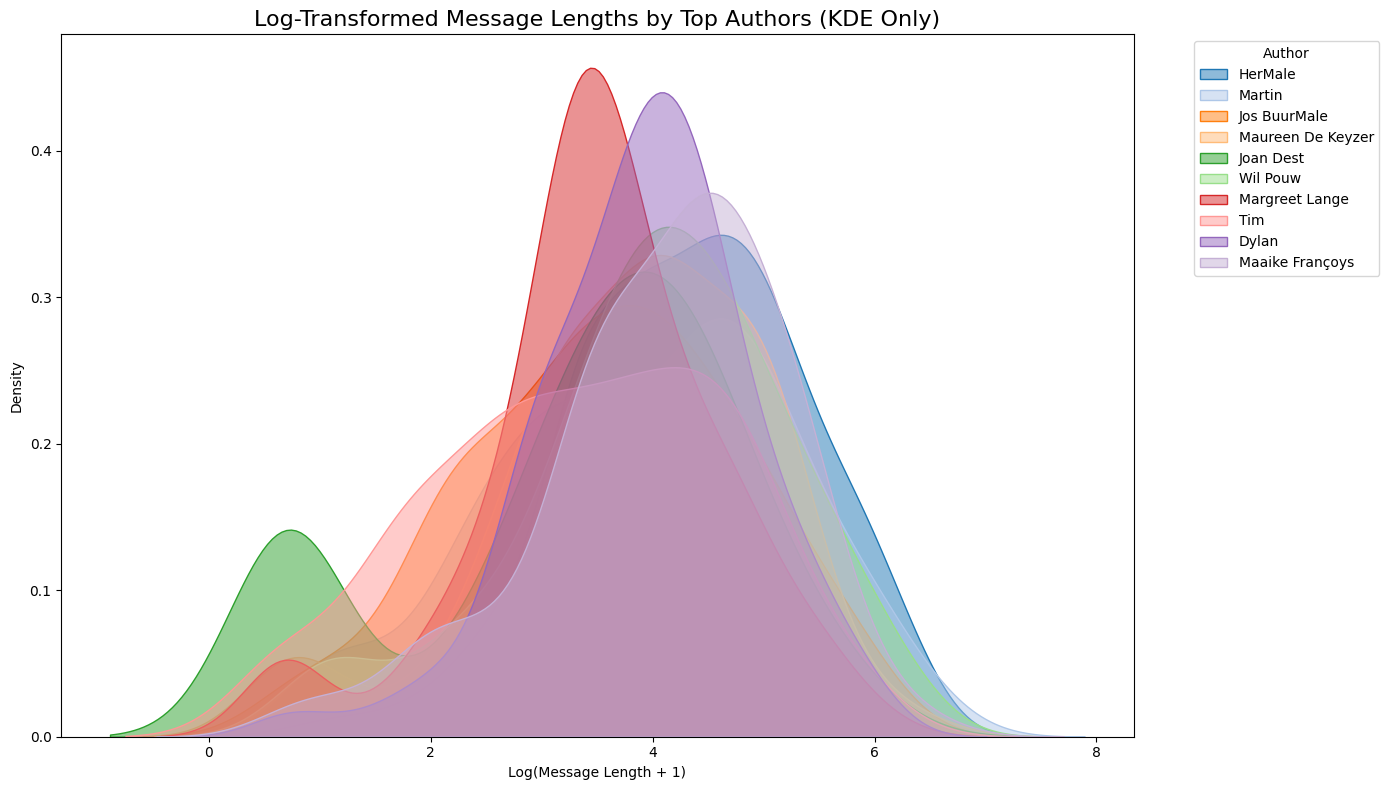

In [41]:
# %%
import numpy as np

# Log-transform message length (+1 to avoid log(0))
df_top['log_msg_length'] = df_top['msg_length'].apply(lambda x: np.log(x + 1))

plt.figure(figsize=(14, 8))

# Get unique authors
authors = df_top['author_name'].unique()
palette = sns.color_palette("tab20", n_colors=len(authors))

# Plot only KDEs
for i, author in enumerate(authors):
    sns.kdeplot(
        data=df_top[df_top['author_name'] == author],
        x='log_msg_length',
        fill=True,
        common_norm=False,
        alpha=0.5,
        color=palette[i],
        label=author
    )

plt.title("Log-Transformed Message Lengths by Top Authors (KDE Only)", fontsize=16)
plt.xlabel("Log(Message Length + 1)")
plt.ylabel("Density")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


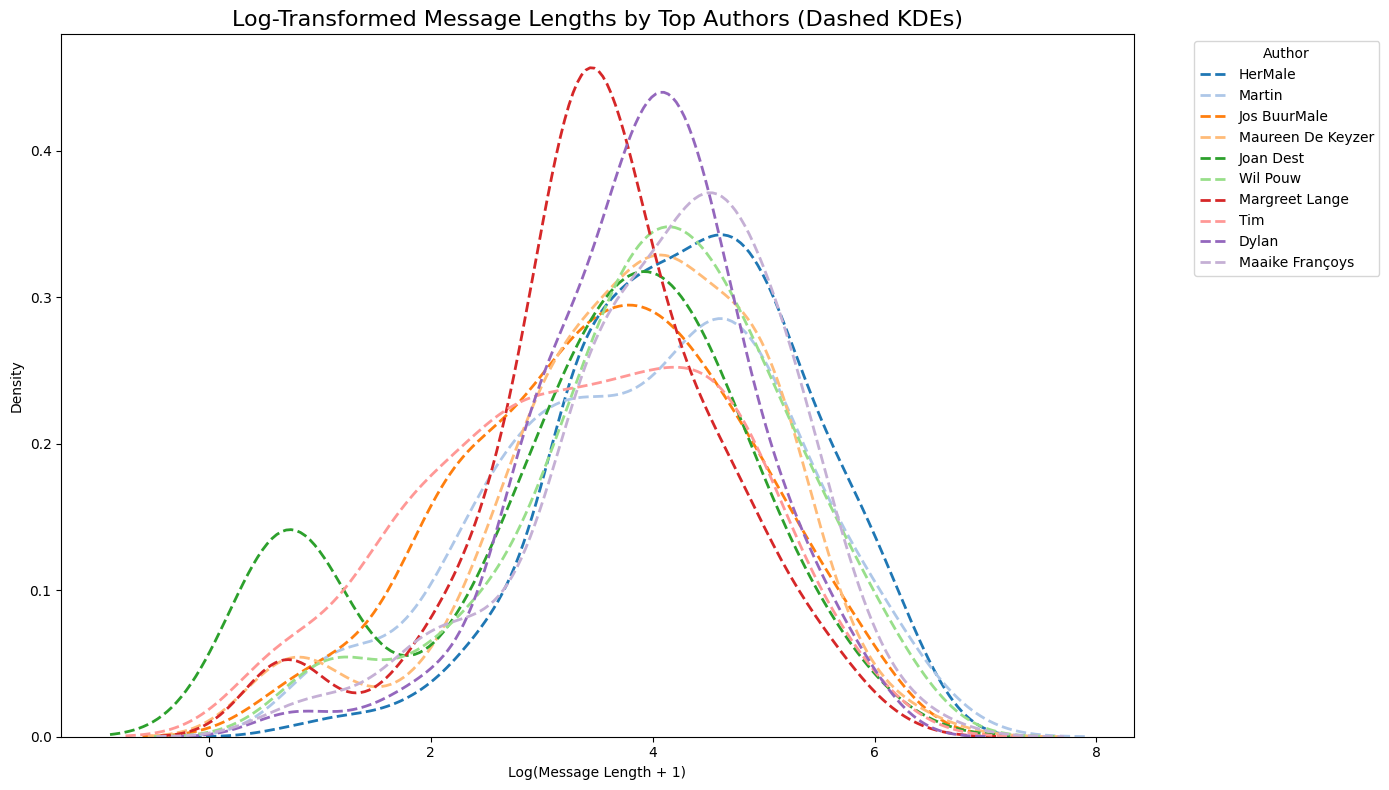

In [42]:
# %%
import numpy as np

# Log-transform message length (+1 to avoid log(0))
df_top['log_msg_length'] = df_top['msg_length'].apply(lambda x: np.log(x + 1))

plt.figure(figsize=(14, 8))

# Get unique authors
authors = df_top['author_name'].unique()
palette = sns.color_palette("tab20", n_colors=len(authors))

# Plot KDEs with dashed lines
for i, author in enumerate(authors):
    sns.kdeplot(
        data=df_top[df_top['author_name'] == author],
        x='log_msg_length',
        fill=False,              # no fill
        common_norm=False,
        linestyle='--',          # dashed lines
        linewidth=2,
        color=palette[i],
        label=author
    )

plt.title("Log-Transformed Message Lengths by Top Authors (Dashed KDEs)", fontsize=16)
plt.xlabel("Log(Message Length + 1)")
plt.ylabel("Density")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


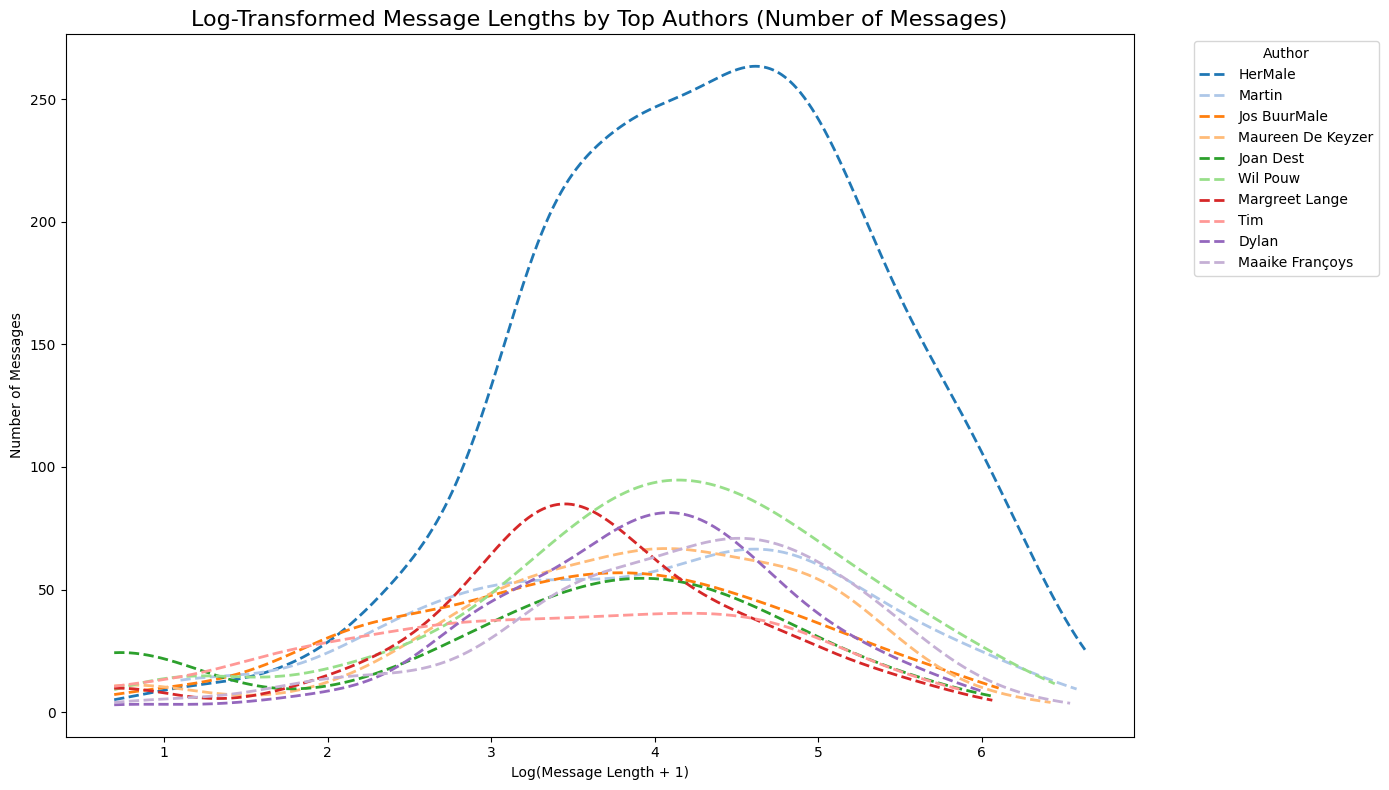

In [43]:
# %%
import numpy as np
from scipy.stats import gaussian_kde

# Log-transform message length (+1 to avoid log(0))
df_top['log_msg_length'] = df_top['msg_length'].apply(lambda x: np.log(x + 1))

plt.figure(figsize=(14, 8))

# Get unique authors
authors = df_top['author_name'].unique()
palette = sns.color_palette("tab20", n_colors=len(authors))

# Plot KDEs scaled to number of messages
for i, author in enumerate(authors):
    author_data = df_top[df_top['author_name'] == author]['log_msg_length']
    
    # Fit KDE
    kde = gaussian_kde(author_data)
    x = np.linspace(author_data.min(), author_data.max(), 1000)
    
    # Scale by number of messages
    y = kde(x) * len(author_data)
    
    # Plot as dashed line
    plt.plot(x, y, linestyle='--', linewidth=2, color=palette[i], label=author)

plt.title("Log-Transformed Message Lengths by Top Authors (Number of Messages)", fontsize=16)
plt.xlabel("Log(Message Length + 1)")
plt.ylabel("Number of Messages")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
